3. With our features and such a large dataset, can we predict the chances for a player to win the game based on game stats: Kills, Heals, Damage Dealt, Walk Distance, Ride Distance, etc. ?

Methodology: Regression. Used 3 regression models to predict the win place for a player based on game statstacis.

Models are Linear Regression, Random Forest, Gradient Boosting Decision Tree.

Metric: R2 score

Best Model: Random Forest



In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from collections import Counter
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import sys

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)
training_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('train_after_prepo.csv')
training_df.take(1)

[Row(_c0=0, Id='7f96b2f878858a', groupId='4d4b580de459be', matchId='a10357fd1a4a91', assists=0, boosts=0, damageDealt=0.0, DBNOs=0, headshotKills=0, heals=0, killPlace=60, killPoints=1241, kills=0, killStreaks=0, longestKill=0.0, matchDuration=1306, matchType='squad-fpp', maxPlace=28, numGroups=26, rankPoints=-1, revives=0, rideDistance=0.0, roadKills=0, swimDistance=0.0, teamKills=0, vehicleDestroys=0, walkDistance=244.8, weaponsAcquired=1, winPoints=1466, winPlacePerc=0.4443, moveDistance=244.8)]

In [4]:
training_df.cache()
training_df.printSchema()

#only consider solo game data
training_df_solo = training_df.filter("matchType = 'solo'")

#The final features used are 'walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt', 
#'heals', 'kills', 'killStreaks', 'longestKill', 'DBNOs', 'headshotKills', 'rideDistance'.
#convert from stringtype to int/double type
training_df_num = training_df_solo.select(training_df.assists.cast("int"), training_df.boosts.cast("int"), \
                                     training_df.damageDealt.cast("double"), training_df.DBNOs.cast("int"),\
                                     training_df.headshotKills.cast("int"),training_df.heals.cast("int"),\
                                     training_df.killPlace.cast("int"),training_df.killPoints.cast("int"),\
                                     training_df.kills.cast("int"),training_df.killStreaks.cast("int"),\
                                     training_df.longestKill.cast("double"),training_df.matchDuration.cast("int"),\
                                     training_df.maxPlace.cast("int"),training_df.numGroups.cast("int"),\
                                     training_df.rankPoints.cast("int"),training_df.revives.cast("int"),\
                                     training_df.rideDistance.cast("double"),training_df.roadKills.cast("int"),\
                                     training_df.swimDistance.cast("double"),training_df.teamKills.cast("int"),\
                                     training_df.vehicleDestroys.cast("int"),training_df.walkDistance.cast("double"),\
                                     training_df.weaponsAcquired.cast("int"),training_df.winPoints.cast("int"),\
                                     training_df.winPlacePerc.cast("double"))

training_df_num.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Id: string (nullable = true)
 |-- groupId: string (nullable = true)
 |-- matchId: string (nullable = true)
 |-- assists: integer (nullable = true)
 |-- boosts: integer (nullable = true)
 |-- damageDealt: double (nullable = true)
 |-- DBNOs: integer (nullable = true)
 |-- headshotKills: integer (nullable = true)
 |-- heals: integer (nullable = true)
 |-- killPlace: integer (nullable = true)
 |-- killPoints: integer (nullable = true)
 |-- kills: integer (nullable = true)
 |-- killStreaks: integer (nullable = true)
 |-- longestKill: double (nullable = true)
 |-- matchDuration: integer (nullable = true)
 |-- matchType: string (nullable = true)
 |-- maxPlace: integer (nullable = true)
 |-- numGroups: integer (nullable = true)
 |-- rankPoints: integer (nullable = true)
 |-- revives: integer (nullable = true)
 |-- rideDistance: double (nullable = true)
 |-- roadKills: integer (nullable = true)
 |-- swimDistance: double (nullable = true)
 |-- teamK

In [5]:
train = training_df_num.toPandas()

In [6]:
type(train)

pandas.core.frame.DataFrame

In [7]:
train.shape

(173521, 25)

In [8]:
# sample without replacement to draw scatter matrix
sampled_data = training_df_num.sample(False, 0.01).toPandas()

In [9]:
sampled_data.head(5)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,2,0.0,0,0,0,61,1468,0,0,...,0,7980.0,0,0.0,0,0,885.5,5,1698,0.4841
1,0,2,339.5,0,1,1,9,1053,3,1,...,0,0.0,0,0.0,0,0,1511.0,4,1458,0.6777
2,0,1,332.2,0,1,0,8,1475,4,2,...,0,0.0,0,0.0,0,0,515.5,3,1542,0.5215
3,0,4,288.0,0,1,4,9,1192,3,1,...,0,0.0,0,0.0,0,0,2528.0,3,1554,0.9565
4,1,2,556.0,0,1,1,7,0,4,1,...,0,0.0,0,70.5,0,0,1459.0,2,0,0.6180


Scatter matrix is a great way to roughly determine if we have a linear correlation between multiple independent variables.

/Users/apple/anaconda3/lib/python3.6/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/apple/anaconda3/lib/python3.6/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
/Users/apple/anaconda3/lib/python3.6/site-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[i])


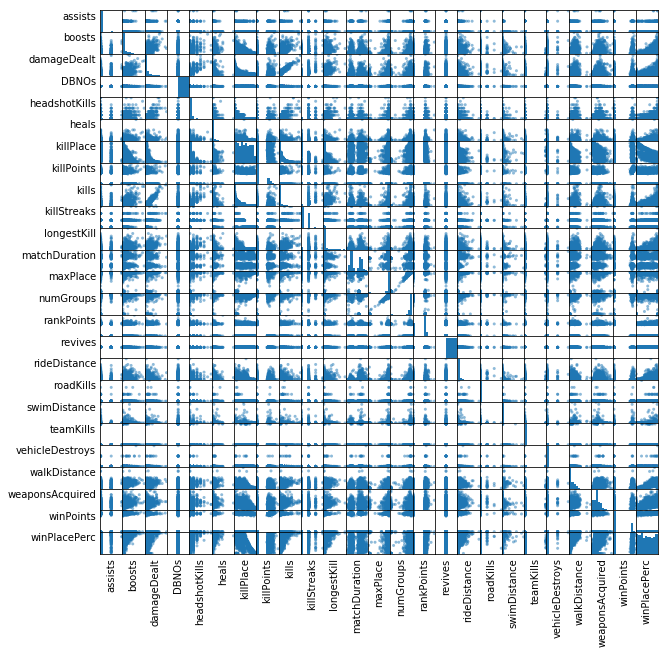

In [10]:
#Use scatter matrix to roughly determine 
#if there's a linear correlation between multiple independent variables.
axs = pd.plotting.scatter_matrix(sampled_data,figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

The correlation coefficient ranges from –1 to 1. 
When it is close to 1, it means that there is a strong positive correlation; 
When the coefficient is close to –1, it means that there is a strong negative correlation; 
Finally, coefficients close to zero mean that there is no linear correlation.

We would like to use those features that are more related to winning palce, which means we need a high correlation between features and winning palce. Here, we choose 0.2 as the threshold.

DBNOs and revives are nan because we only use solo data here, where we neither have teammates that can be revived nor could knock down someone without killing him or her.

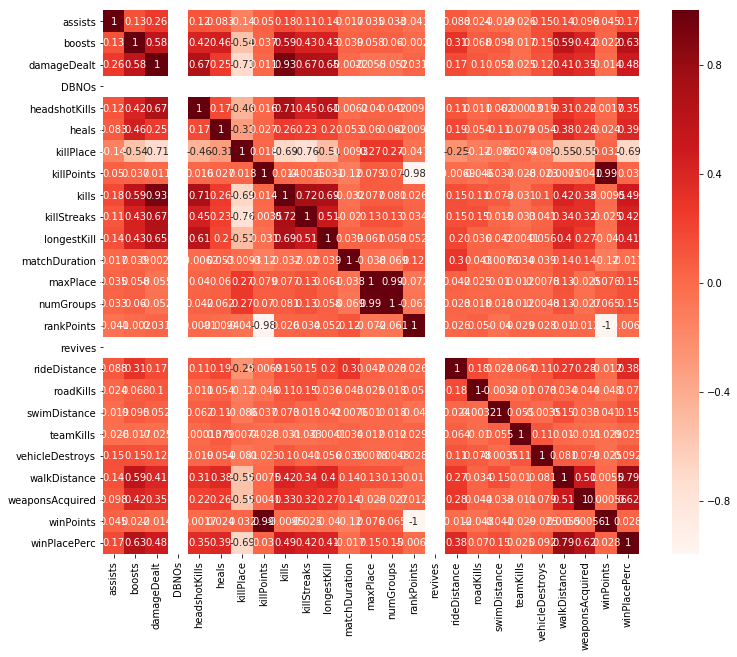

In [11]:
#Using Pearson Correlation to draw a correlation heatmap
#The correlation coefficient ranges from –1 to 1. 
#When it is close to 1, it means that there is a strong positive correlation; 
#When the coefficient is close to –1, it means that there is a strong negative correlation; 
#Finally, coefficients close to zero mean that there is no linear correlation.
plt.figure(figsize=(12,10))
cor = sampled_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [12]:
#display each correlation w.r.t win place respectively
import six
print('Correlation to win place:')
inputColumns = []
for i in training_df_num.columns:
    if not( isinstance(training_df_num.select(i).take(1)[0][0], six.string_types)):
        print(i, ":",  training_df_num.stat.corr('winPlacePerc',i))
        if abs(training_df_num.stat.corr('winPlacePerc',i)) > 0.2:
            inputColumns.append(i)
del inputColumns[-1]

Correlation to win place:
assists : 0.16328422951494426
boosts : 0.6265404749128476
damageDealt : 0.46602128652885966
DBNOs : nan
headshotKills : 0.3266781950282396
heals : 0.39137342819190496
killPlace : -0.698505518283682
killPoints : 0.042932143271533066
kills : 0.49202588438031497
killStreaks : 0.4344775745090947
longestKill : 0.41469334662906493
matchDuration : -0.01488340173247269
maxPlace : 0.1761397693092209
numGroups : 0.17476283137646692
rankPoints : -0.016829074420117836
revives : nan
rideDistance : 0.3545438500383182
roadKills : 0.055823030848289275
swimDistance : 0.1530944729106027
teamKills : 0.017441029092505982
vehicleDestroys : 0.0784427641290215
walkDistance : 0.7954031640905772
weaponsAcquired : 0.5789706919751876
winPoints : 0.035915803252562654
winPlacePerc : 1.0


# Feature Selection: 
From the matrix & corr above, drop DBNOs, revives, matchDuration, rankPoints, teamKills, winPoints

In [13]:
train = train.drop(['DBNOs','revives','matchDuration','rankPoints','teamKills','winPoints'], axis = 1)
train.shape

(173521, 19)

In [14]:
#split 30% of data as test data
train,test = train_test_split(train, test_size=0.3)
train.shape,test.shape

((121464, 19), (52057, 19))

In [15]:
#get label for train & test data respectively
y_train = train['winPlacePerc']
train = train.drop(['winPlacePerc'], axis = 1)
y_test = test['winPlacePerc']
test = test.drop(['winPlacePerc'], axis = 1)
y_train.shape,y_test.shape, train.shape, test.shape

((121464,), (52057,), (121464, 18), (52057, 18))

In [16]:
column_name = train.columns.values.tolist()
column_name

['assists',
 'boosts',
 'damageDealt',
 'headshotKills',
 'heals',
 'killPlace',
 'killPoints',
 'kills',
 'killStreaks',
 'longestKill',
 'maxPlace',
 'numGroups',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired']

In [17]:
#normalize data
train_norm = normalize(train)
test_norm = normalize(test)

In [18]:
type(train_norm)

numpy.ndarray

# Metrics for regression: 

R2_Score: The coefficient of determination R^2 of the prediction.

The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

# 1st: Linear Regression

In [59]:
lr_res = LinearRegression().fit(train_norm, y_train)

In [64]:
print('Score: ',lr_res.score(train_norm, y_train))
lr_coef = lr_res.coef_
print('Coefficients:')
for i,item in enumerate(lr_coef):
    print('\t',column_name[i],item)

Score:  0.6921527949424652
Coefficients:
	 assists 15.418624734050358
	 boosts 19.011252824443265
	 damageDealt -0.11694766852573765
	 headshotKills 2.3847161434516853
	 heals 0.41072654236128464
	 killPlace -0.39973043973716127
	 killPoints -0.014581687967331359
	 kills 63.4372980545498
	 killStreaks -81.75039350264045
	 longestKill 0.3563293960802572
	 maxPlace -0.14790284592945488
	 numGroups -0.1345359063297152
	 rideDistance 0.2916706135899385
	 roadKills -41.24397691098913
	 swimDistance 0.45993015800393117
	 vehicleDestroys -19.425280647463097
	 walkDistance 0.3971871783600804
	 weaponsAcquired 0.1052254012011602


In [65]:
#predict on test set, see if score matches 
print('Score on test set:',lr_res.score(test_norm, y_test))

Score on test set: 0.6874565274728335


# 2nd: Random Forest 

In [19]:
res_rf = RandomForestRegressor(n_estimators=100).fit(train_norm, y_train)

In [20]:
print('Score:',res_rf.score(train_norm, y_train))
print('Feature importances:')
for i,item in enumerate(res_rf.feature_importances_):
    print('\t',column_name[i],item)

Score: 0.989812603972824
Feature importances:
	 assists 0.0006133732270561661
	 boosts 0.010769122441370802
	 damageDealt 0.0068239210781187885
	 headshotKills 0.001649553962720778
	 heals 0.003374550824540573
	 killPlace 0.7234091571945886
	 killPoints 0.005462745431784515
	 kills 0.019056813673108332
	 killStreaks 0.007375138070123588
	 longestKill 0.0051662425065904325
	 maxPlace 0.014934520994875133
	 numGroups 0.05043531327826531
	 rideDistance 0.004981660975958037
	 roadKills 0.00018458115531398895
	 swimDistance 0.0011891002397190515
	 vehicleDestroys 0.00013342135789230867
	 walkDistance 0.1350488900060681
	 weaponsAcquired 0.009391893581905487


In [23]:
#display top 10 important features
hashed = {}
for i,item in enumerate(res_rf.feature_importances_):
    hashed[item] = column_name[i]
keys = list(hashed.keys())
keys.sort()
print('Top 10 important features:')
for item in reversed(keys[-10:]):
    print('   ',hashed[item],item)

Top 10 important features:
    killPlace 0.7234091571945886
    walkDistance 0.1350488900060681
    numGroups 0.05043531327826531
    kills 0.019056813673108332
    maxPlace 0.014934520994875133
    boosts 0.010769122441370802
    weaponsAcquired 0.009391893581905487
    killStreaks 0.007375138070123588
    damageDealt 0.0068239210781187885
    killPoints 0.005462745431784515


In [22]:
#predict on test set, see if score matches 
print('Score on test set:',res_rf.score(test_norm, y_test))

Score on test set: 0.9260240762966434


Score on test set is lower than that on training set, showing a trend in overfitting

# 3rd: Gradient Boosting

In [79]:
res_gb = GradientBoostingRegressor(validation_fraction = 0.2).fit(train_norm, y_train)

In [81]:
print('Score:',res_gb.score(train_norm, y_train))

Score: 0.8758755800889798


In [89]:
#predict on test set, see if score matches 
print('Score on test set:',res_gb.score(test_norm, y_test))

Score on test set: 0.8728776388698402


Score on test set is nearly the same as that on training set, show very little sign on overfitting, but the performance is worse than Random Forest

# Summary:
Based on the performance of 3 regressors above, the Random Forest Regressor is the best, in which killPlace, walkDistance, numGroups, kills, maxPlace are top 5 important factors


In [116]:
# predict on some samples using Random Forest Regressor
pred = res_rf.predict(test_norm[:20])

In [120]:
print('Index: Label | Prediction')
for i,item in enumerate(y_test[:20]):
    print(i,':',item, '|',pred[i])

Index: Label | Prediction
0 : 0.264 | 0.327454
1 : 0.2104 | 0.20344781666666678
2 : 0.8525 | 0.7354000000000004
3 : 0.7554 | 0.6892366
4 : 0.0928 | 0.105902
5 : 0.5273 | 0.46890419999999994
6 : 0.3723 | 0.34603871428571437
7 : 0.296 | 0.4638810000000003
8 : 0.3894 | 0.4103666666666666
9 : 0.5625 | 0.5159577999999998
10 : 0.1475 | 0.15498800000000004
11 : 0.72 | 0.8160994999999999
12 : 0.617 | 0.6347707857142851
13 : 0.4631 | 0.3661271333333334
14 : 0.379 | 0.3483480000000003
15 : 0.8174 | 0.8508504999999995
16 : 0.4783 | 0.414971
17 : 0.0899 | 0.0933767142857143
18 : 0.506 | 0.552192
19 : 0.0 | 0.0
